https://www.dbpia.co.kr/pdf/pdfView.do?nodeId=NODE11120613&googleIPSandBox=false&mark=0&ipRange=false&b2cLoginYN=false&isPDFSizeAllowed=true&accessgl=Y&language=ko_KR&hasTopBanner=true

해당 논문을 통해 Pororo모델을 사용해 기사 본문 축약 및 감성분석을 진행하려고 하였으나, 난이도로 인해 LSTM 감성분석으로 변경

Konlpy 모듈 설치

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-11-28 02:15:31--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-11-28 02:15:32--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucda85f8c30c47c77ec4e301b5d3.dl.dropboxusercontent.com/cd/0/get/CIVR_r8Q3PFNlTjOpWFmSFBbE0bwzZylvVod9YRQzrwdLj7X9SDqF9sAFLYsnJQ6uiRkh03MeqxkCYximIon6qnpgr0dzrxr8kVdRi6UvBULJY85rOUeu81lDyCDLLlDPFiHg_rAiBivUjp66ZBIbMi9/file?dl=1# [following]
--2023-11-28 02:15:33--  https://ucda85f8c30c47c77ec4e301b5d3.dl.dropboxusercontent.com/cd/0/get/CIVR_r8Q3PFNlTjOpWFmSFBbE0bwzZylvVod9YRQzrwdLj7X9SDq

라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

감성분석 데이터 출처

https://github.com/e9t/nsmc/tree/master

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7eecf8c2b460>)

In [ ]:
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

print("train_data =", train_data.shape)
print("test_data =", test_data.shape)

train_data = (150000, 3)
test_data = (50000, 3)


학습데이터 분포량 확인

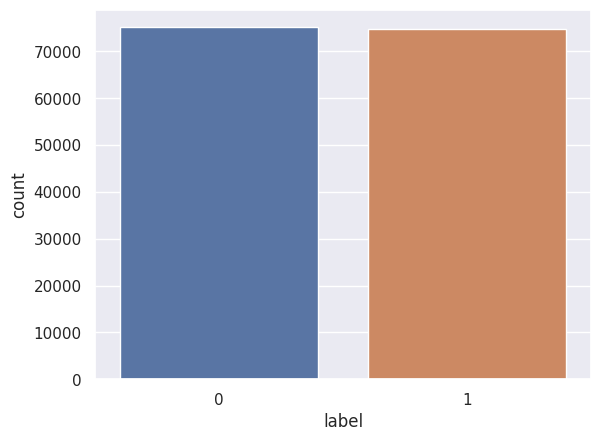

In [ ]:
sb.set_theme(style="darkgrid")
graph = sb.countplot(x="label", data = train_data)


전처리

In [ ]:
tokenizer = Komoran()

def PreProcess(train_data, test_data):
  train_data.drop_duplicates(subset=["document"], inplace = True)
  test_data.drop_duplicates(subset=["document"], inplace = True)
  train_data = train_data.dropna()
  test_data = test_data.dropna()
  print("train shape =", train_data.shape)
  print("test shape =", test_data.shape)
  train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train_data['document']]
  test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test_data['document']]

  exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                    'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                    'XSN', 'XSV', 'XSA']

  f = lambda x: x in exclusion_tags

  X_train = []
  for i in range(len(train_tokenized)):
      temp = []
      for j in range(len(train_tokenized[i])):
          if f(train_tokenized[i][j].split('/')[1]) is False:
              temp.append(train_tokenized[i][j].split('/')[0])
      X_train.append(temp)

  X_test = []
  for i in range(len(test_tokenized)):
      temp = []
      for j in range(len(test_tokenized[i])):
          if f(test_tokenized[i][j].split('/')[1]) is False:
              temp.append(test_tokenized[i][j].split('/')[0])
      X_test.append(temp)

  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(30000-4)
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))

  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [ ]:
X_train, y_train, X_test, y_test, word_to_index = PreProcess(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

train shape = (146182, 3)
test shape = (49157, 3)


토큰 길이 설정

In [ ]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print("최대 길이 :", maxlen)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

최대 길이 : 28


LSTM 모델링

In [ ]:
vocab_size = 30000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          480000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 480809 (1.83 MB)
Trainable params: 480809 (1.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=800)

모델 훈련

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=512,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/5
229/229 [==============================] - 24s 72ms/step - loss: 0.5447 - accuracy: 0.7551 - val_loss: 0.4100 - val_accuracy: 0.8227
Epoch 2/5
229/229 [==============================] - 14s 61ms/step - loss: 0.3708 - accuracy: 0.8411 - val_loss: 0.3721 - val_accuracy: 0.8374
Epoch 3/5
229/229 [==============================] - 14s 62ms/step - loss: 0.3297 - accuracy: 0.8633 - val_loss: 0.3662 - val_accuracy: 0.8397
Epoch 4/5
229/229 [==============================] - 16s 71ms/step - loss: 0.3057 - accuracy: 0.8760 - val_loss: 0.3709 - val_accuracy: 0.8377
Epoch 5/5
229/229 [==============================] - 14s 61ms/step - loss: 0.2867 - accuracy: 0.8858 - val_loss: 0.3801 - val_accuracy: 0.8359


loss값 + accuracy 출력

In [ ]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 13s 9ms/step - loss: 0.3879 - accuracy: 0.8347
[0.38792553544044495, 0.8346522450447083]
